# Exportar un modelo de ML

Para la presente actividad se utilizará el **Diabetes Dataset**, el cual puede ser encontrado en el siguiente enlace:

https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

El objetivo de este proyecto es desarrollar un modelo de *Machine Learning* capaz de predecir si una persona presenta diabetes, basándose en un conjunto de características clínicas y demográficas.  
Este modelo será posteriormente exportado para su uso en una aplicación externa, donde se realizará inferencia a partir de datos de entrada proporcionados por el usuario.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort

In [60]:
data = pd.read_csv("data/diabetes.csv")

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA

In [61]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Text(0.5, 1.0, "Distribución de la variable objetivo 'Outcome'")

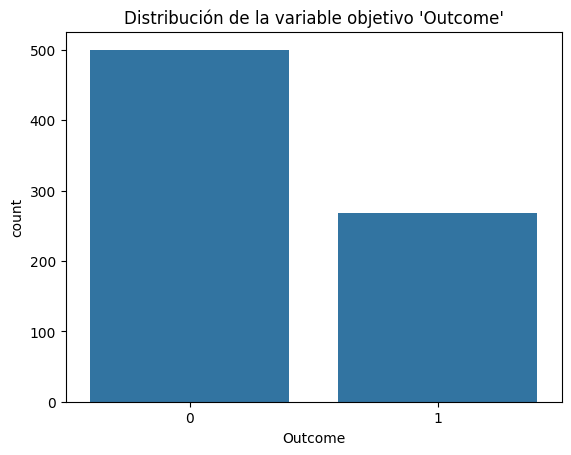

In [62]:
sns.countplot(x="Outcome", data=data)
plt.title("Distribución de la variable objetivo 'Outcome'")

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


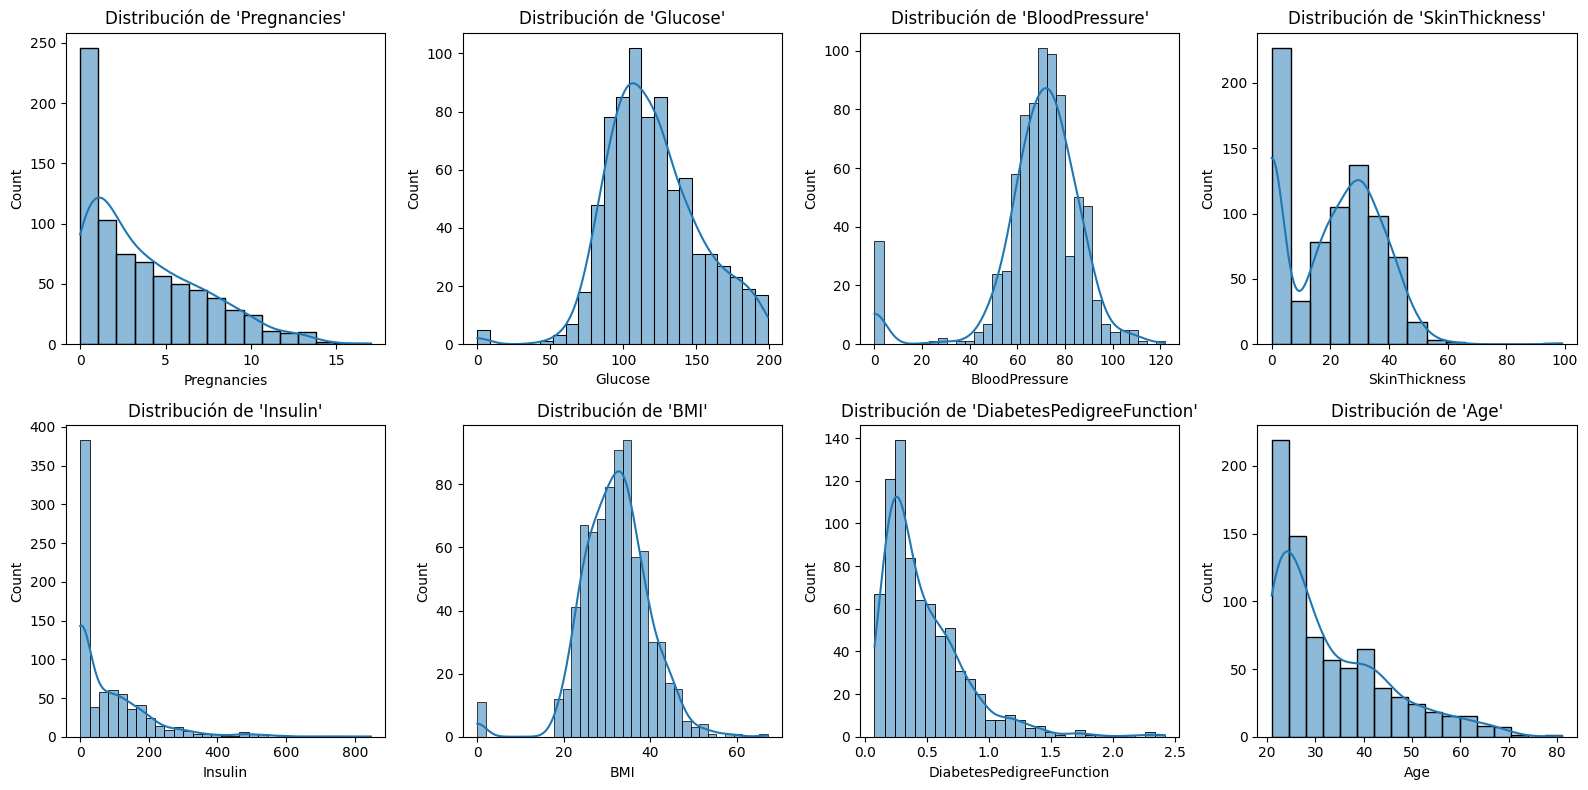

In [64]:
numerical_features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax, col in zip(axs.ravel(), numerical_features):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de \'{col}\'')

fig.tight_layout()

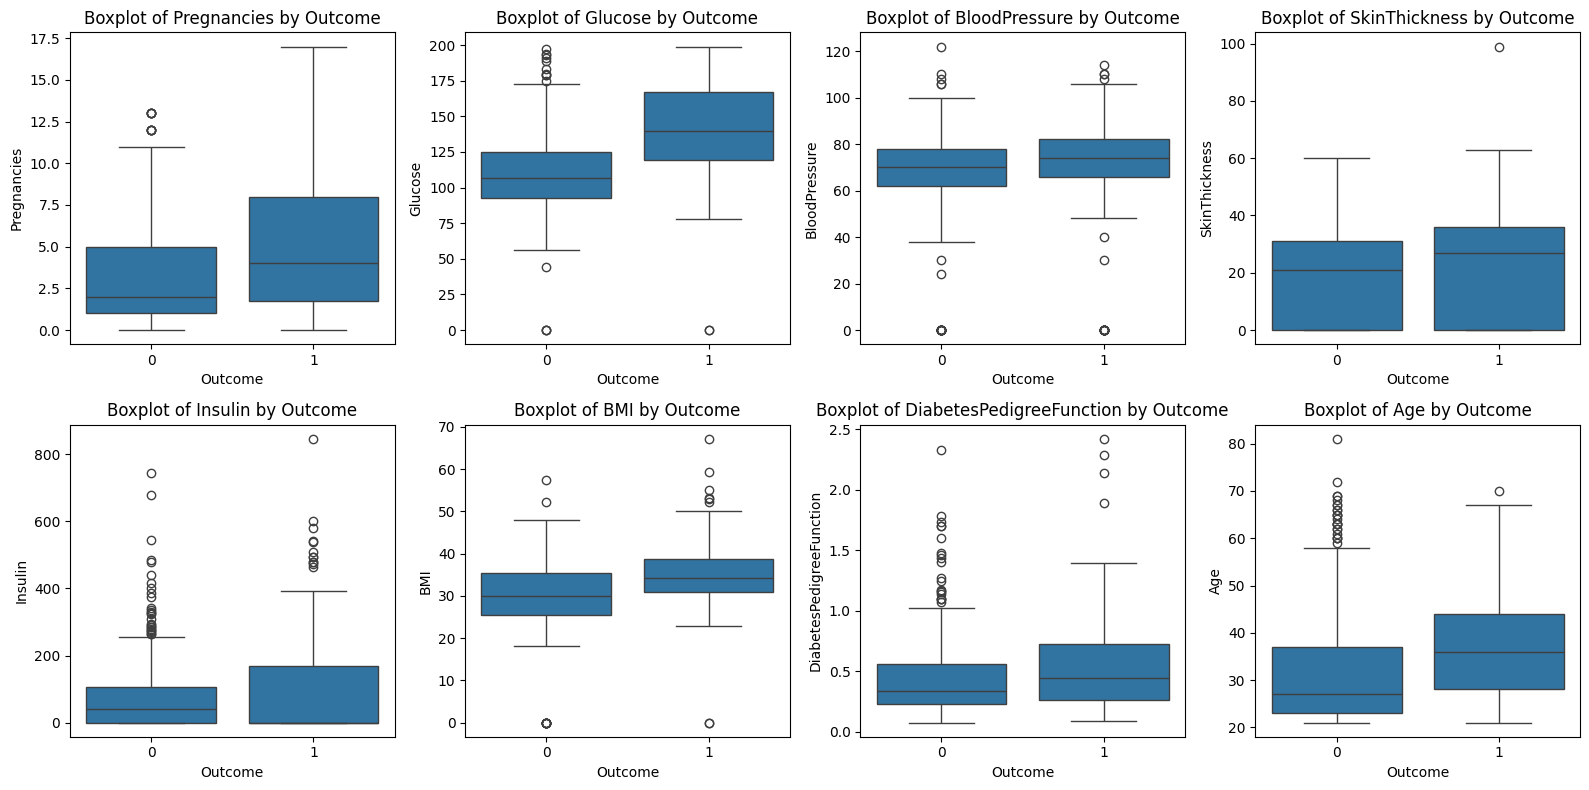

In [65]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax, col in zip(axs.ravel(), numerical_features):
    sns.boxplot(data=data, x='Outcome', y=col, ax=ax)
    ax.set_title(f'Boxplot of {col} by Outcome')

fig.tight_layout()

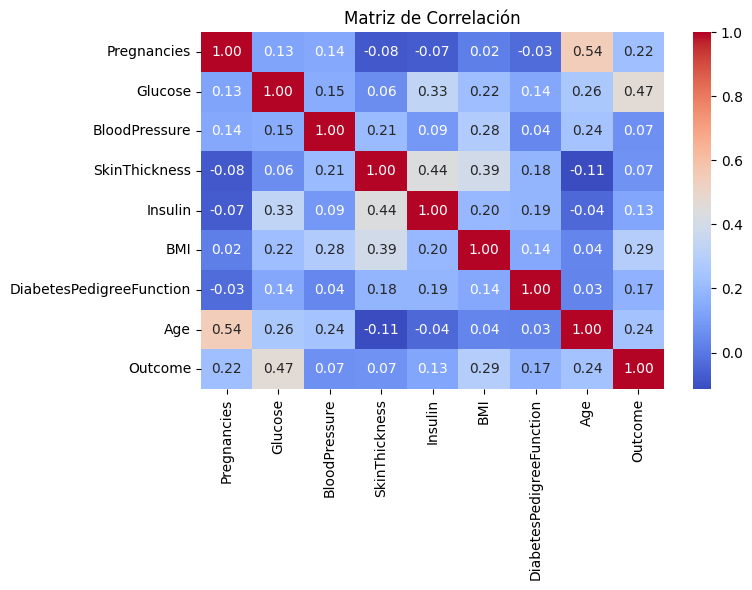

In [66]:
corr_matrix = data[numerical_features + ['Outcome']].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()

<Axes: >

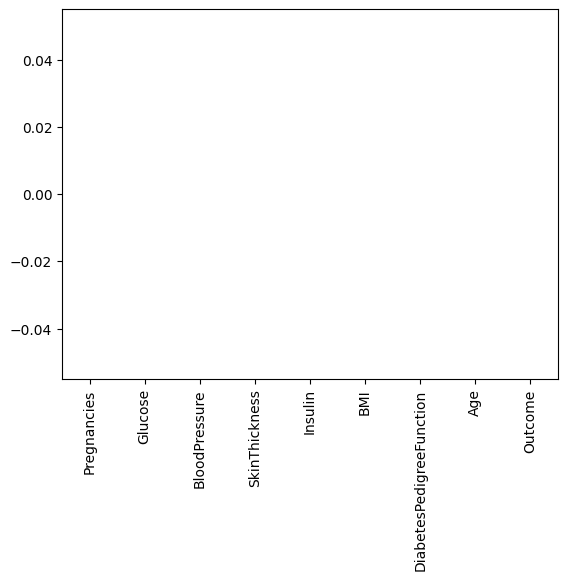

In [67]:
missing_counts = data.isnull().sum()
missing_counts.plot(kind='bar')

In [68]:
missing_percent = data.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

## Preprocesamiento

In [69]:
preprocessing_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            # Variables con PowerTransformer + StandardScaler
            (
                'num_power_scaled',
                make_pipeline(
                    SimpleImputer(strategy='mean'),
                    PowerTransformer(),
                    StandardScaler()
                ),
                [
                    'Pregnancies',
                    'SkinThickness',
                    'Insulin',
                    'DiabetesPedigreeFunction',
                    'Age'
                ]
            ),

            # Variables solo con StandardScaler
            (
                'num_scaled',
                make_pipeline(
                    SimpleImputer(strategy='mean'),
                    StandardScaler()
                ),
                [
                    'Glucose',
                    'BloodPressure',
                    'BMI'
                ]
            )
        ],
        remainder='drop'  # No dejamos columnas sin transformar
    )
)

## Entrenamiento

In [70]:
x = data[numerical_features] 
y = data['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

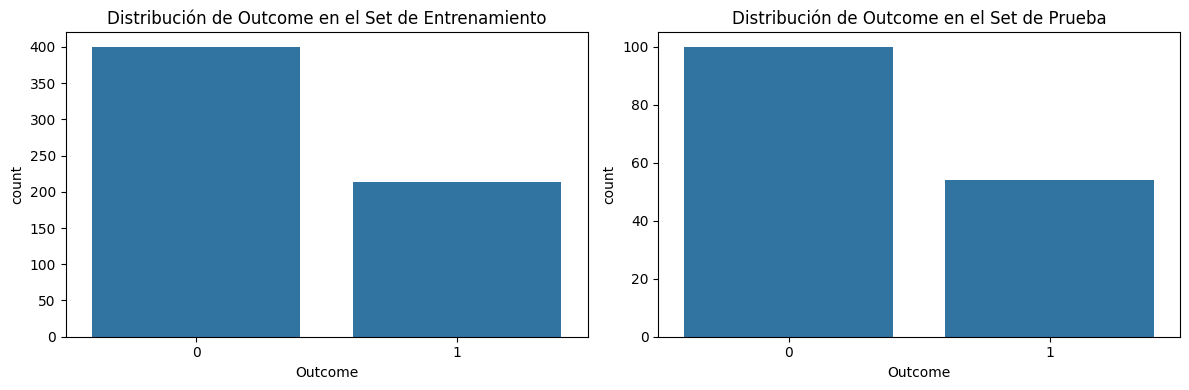

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Distribución de Outcome en el Set de Entrenamiento')
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Distribución de Outcome en el Set de Prueba')
fig.tight_layout()

In [72]:
pipe_lr = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['lbfgs']
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_lr.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__C': [0.01, 0.1, ...], 'model__solver': ['lbfgs']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- 

In [73]:
pipe_rf = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_rf.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 5, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate i

In [74]:
pipe_svm = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', SVC())
])

param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale']
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_svm.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...del', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__C': [0.1, 1, ...], 'model__gamma': ['scale'], 'model__kernel': ['linear', 'rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >

In [75]:
# BEST MODELS FROM GRID SEARCH
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_

models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'SVM': best_svm
}

print("Recall comparison (Train vs Test)\n")

for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Metric
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    print(f"{name}")
    print(f"  Train Recall: {train_recall:.3f}")
    print(f"  Test Recall:  {test_recall:.3f}")
    print(f"  Difference:   {train_recall - test_recall:.3f}\n")

Recall comparison (Train vs Test)

Logistic Regression
  Train Recall: 0.603
  Test Recall:  0.500
  Difference:   0.103

Random Forest
  Train Recall: 1.000
  Test Recall:  0.593
  Difference:   0.407

SVM
  Train Recall: 0.780
  Test Recall:  0.574
  Difference:   0.206



## Evaluación

In [76]:
model = best_svm

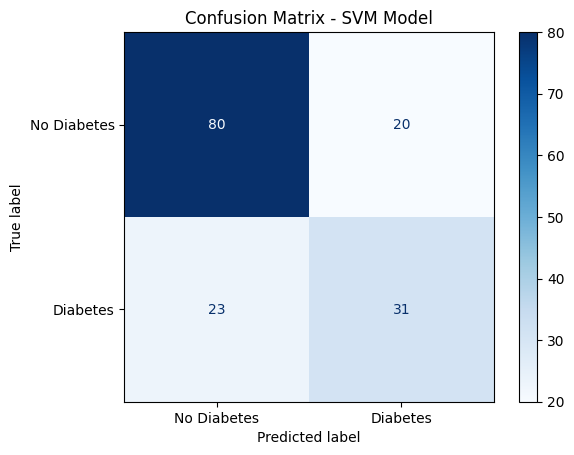

In [80]:
# Predictions of the best model (SVM)
y_test_pred = model.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Diabetes', 'Diabetes']
)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM Model')
plt.show()

In [81]:
print("Classification Report - SVM Model\n")
print(classification_report(y_test, y_test_pred))

Classification Report - SVM Model

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       100
           1       0.61      0.57      0.59        54

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154



## Serialización

In [82]:
# Definición de las entradas del modelo
initial_types = [
    ('Pregnancies', FloatTensorType([None, 1])),
    ('Glucose', FloatTensorType([None, 1])),
    ('BloodPressure', FloatTensorType([None, 1])),
    ('SkinThickness', FloatTensorType([None, 1])),
    ('Insulin', FloatTensorType([None, 1])),
    ('BMI', FloatTensorType([None, 1])),
    ('DiabetesPedigreeFunction', FloatTensorType([None, 1])),
    ('Age', FloatTensorType([None, 1]))
]

# Conversión a ONNX
onnx_model = convert_sklearn(
    model,                # best_svm (pipeline completo)
    initial_types=initial_types,
    target_opset=12
)

# Guardar modelo
with open("diabetes_svm_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## Prueba de Serialización

In [83]:
# ==============================
# 1. Tomar 5 muestras de prueba
# ==============================
X_sample = x_test.iloc[:5]
y_true = y_test.iloc[:5].values

# ==============================
# 2. Predicciones con sklearn
# ==============================
sklearn_preds = model.predict(X_sample)

# ==============================
# 3. Cargar modelo ONNX
# ==============================
sess = ort.InferenceSession("diabetes_svm_model.onnx")

# Obtener nombres de entradas ONNX
input_names = [inp.name for inp in sess.get_inputs()]

# ==============================
# 4. Preparar inputs para ONNX
# ==============================
onnx_inputs = {
    name: X_sample[name].to_numpy().astype(np.float32).reshape(-1, 1)
    for name in input_names
}

# ==============================
# 5. Predicciones con ONNX
# ==============================
onnx_preds = sess.run(None, onnx_inputs)[0].ravel().astype(int)

# ==============================
# 6. Tabla comparativa
# ==============================
results_df = pd.DataFrame({
    'True Label': y_true,
    'Sklearn Prediction': sklearn_preds,
    'ONNX Prediction': onnx_preds,
    'Match': sklearn_preds == onnx_preds
})

results_df

,True Label,Sklearn Prediction,ONNX Prediction,Match
0,0,1,1,True
1,0,0,0,True
2,0,0,0,True
3,1,0,0,True
4,0,0,0,True
